# Exploring the results

In [58]:
from pathlib import Path
from typing import List

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
from tqdm.auto import tqdm

tqdm.pandas()

In [222]:
# # Plotting settings

sns.set_context("paper")
sns.set(
    font_scale=1.1,
#     rc={
#         "font.family": "sans-serif",
#         "font.size": 14.0,
#     }
)

# figure sizes:
big = 12
full = 7.25
reg = 5
small= 3.54

def get_figsize(w, ratio=0.625):
    return (w, w*ratio)

palette = "Paired"

In [4]:
# Data directories
data_dir = Path("../data")

raw_dir = data_dir / "raw"
pubmed_dir = raw_dir / "pubmed"
scite_dir = raw_dir / "scite"

processed_dir = data_dir / "processed"

results_dir = data_dir / "results"

## Functions

In [251]:
def article_profiles(
    dois: List,
    pattern: str = "mentions_norm_mean",
    norm_line: bool = False,
    common_authors: bool = False,
    norm_refs: bool = False,
    norm_eng: bool = False,
    color: str = None,
    alpha: float = None,
    palette: str = None,
    scatter: bool = True,
    title: str = None,
    xlabel: str = None,
    ylabel: str = None,
    ax=None,
):
    cit_subset = citation_patterns[citation_patterns.target.isin(dois)]
    
    if ax is None:
        fig, ax = plt.subplots(1, 1)
    
    if norm_line:
        max_cit = cit_subset.groupby("target").size().max()  
        ax.hlines(1, 0, max_cit, linestyles="dashed")

    n_dois = len(dois)

    if color is None:
        colors = sns.color_palette(palette, n_colors=n_dois)
    else:
        colors = [color] * n_dois
    
    # Plot each article profile
    with sns.axes_style("white"):
        for doi, color in tqdm(zip(dois, colors), total=n_dois, leave=False):
            pdf = cit_subset[cit_subset.target == doi].copy()
            pdf = pdf.sort_values(pattern)

            # Normalize values if needed
            if norm_refs:
                pdf["x_perc"] = pdf[pattern].rank(method="first") - 1
                pdf["x_perc"] = pdf["x_perc"] / pdf["x_perc"].max()
            else:
                pdf["x_perc"] = pdf[pattern].rank(method="first")

            if norm_eng:
                pdf[pattern] = pdf[pattern] / pdf[pattern].max()

            if common_authors:
                pdf["common_authors"] = pdf["common_authors"] > 0
                style = "common_authors"
            else:
                style = None

            sns.lineplot(
                data=pdf, x="x_perc", y=pattern, zorder=1, color=color, ax=ax, alpha=alpha
            )

            if scatter:
                sns.scatterplot(
                    data=pdf,
                    x="x_perc",
                    y=pattern,
                    size="mentions",
                    style=style,
                    color=color,
                    sizes=(20, 200),
                    legend=False,
                    zorder=2,
                    alpha=alpha,
                    ax=ax,
                )
    return ax

## Load data

In [6]:
metadata = pd.read_csv(processed_dir / "contexts.csv", index_col="doi")
mention_patterns = pd.read_csv(processed_dir / "mention_patterns.csv", index_col=0)
citation_patterns = pd.read_csv(processed_dir / "citation_patterns.csv", index_col=0)
article_patterns = pd.read_csv(processed_dir / "article_patterns.csv", index_col=0)

article_patterns["age"] = 2021 - metadata.year

In [7]:
col_names = {
    "refs_agg": "Ref count",
    "mentions_agg": "Mention count",
    "refs_frac_agg": "Frac. ref count",
    "mentions_frac_agg": "Frac. mention count",
    "rte_avg": "RTE-AVG",
    "rte_med": "RTE-MED",
    "rte_c": "RTE-C",
    "age": "Publication age",
}

## Plots and tables

In [189]:
cit_col_names = {
    "mentions": "Mentions",
    "refs_norm": "Frac reference",
    "mentions_norm_total": "Frac mentions",
    "mentions_norm_mean": "RTE"
}
select_cols = ["mentions", "refs_norm", "mentions_norm_total", "mentions_norm_mean"]
df = citation_patterns[select_cols].rename(columns=cit_col_names)
df.describe()

,Mentions,Frac reference,Frac mentions,RTE
count,10912.000000,10912.000000,10912.000000,10912.000000
mean,1.637647,0.022037,0.023412,1.074685
std,1.426386,0.025169,0.032650,0.772032
min,1.000000,0.000912,0.000701,0.153846
25%,1.000000,0.010101,0.008403,0.685341
50%,1.000000,0.016949,0.014493,0.812500
75%,2.000000,0.025641,0.025924,1.195017
max,20.000000,0.500000,0.625000,10.263158


<Figure size 522x522 with 0 Axes>

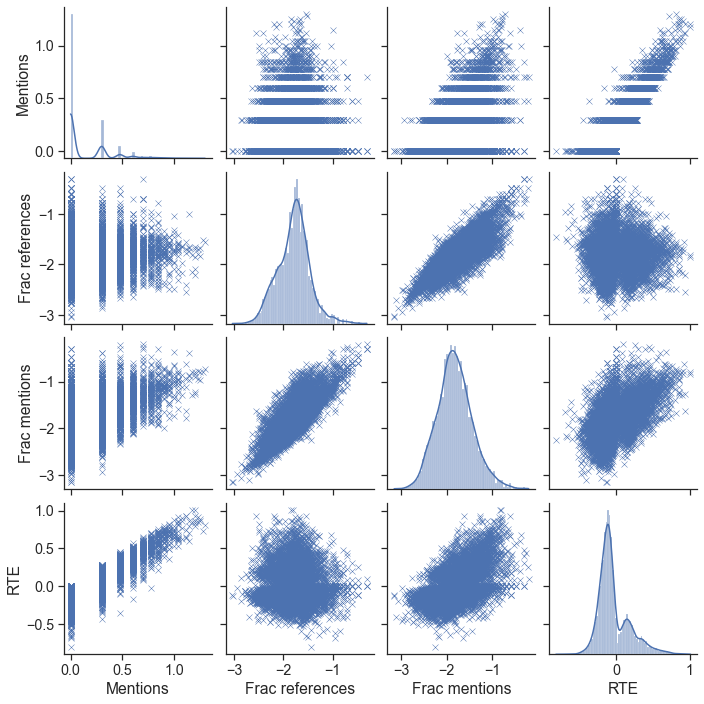

In [140]:
style = "ticks"
plt.figure(figsize=(full_width, full_width))

with sns.axes_style(style):
    g = sns.pairplot(
        np.log10(df),
        plot_kws=dict(marker="x"),
        diag_kws=dict(kde=True)
    )

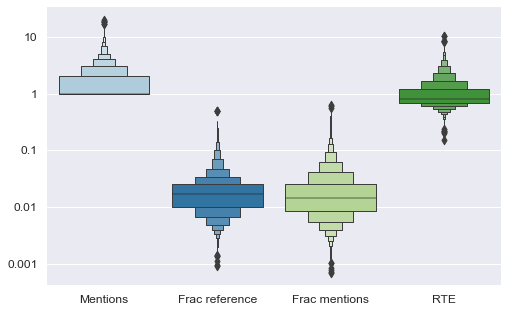

In [227]:
plt.figure(figsize=get_figsize(full))
with sns.axes_style("darkgrid"):
    pdf = df.melt(var_name="Metric", value_name="Count")
    sns.boxenplot(data=pdf, x="Metric", y="Count", palette=palette)
    
    # formatting
    plt.yscale("log");
    
    ticks = [.001, .01, .1, 1, 10]
    plt.yticks(ticks=ticks, labels=ticks);
    plt.xticks(rotation=0, ha="center");
    
    plt.xlabel("")
    plt.ylabel("")
    
    sns.despine(left=True, bottom=True, top=True, right=True)
    plt.tight_layout()

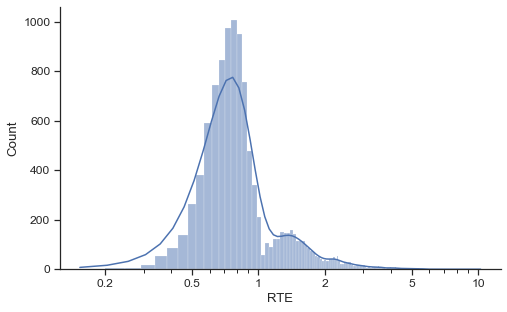

In [223]:
w, h = get_figsize(full)
with sns.axes_style("ticks"):
    sns.displot(df["RTE"], height=h, aspect=w/h, kde=True)
    plt.xscale("log")
    xticks = [.2, .5, 1, 2, 5, 10]
    plt.xticks(ticks=xticks, labels=xticks)

### Introducing RTE based metrics

In [224]:
dois = article_patterns.sample(10, random_state=2).index

#### RTE-AVG

  0%|          | 0/10 [00:00<?, ?it/s]

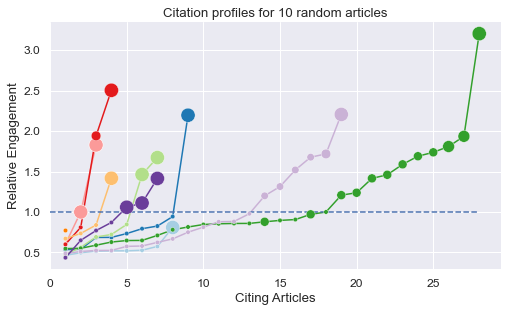

In [253]:
title = f"Citation profiles for {len(dois)} random articles"
xlabel = "Citing Articles"
ylabel = "Relative Engagement"

f, ax = plt.subplots(1, 1, figsize=get_figsize(full))
# with sns.axes_style("white"):
ax = article_profiles(dois, palette=palette, norm_line=True, ax=ax)

# captions
ax.set_title(title)
ax.set_xlabel(xlabel)
ax.set_ylabel(ylabel);

# limits
x0, x1 = plt.xlim()
plt.xlim(0, x1)

sns.despine(left=True, bottom=True, right=True)
plt.tight_layout()

#### RTE-C

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/10 [00:00<?, ?it/s]

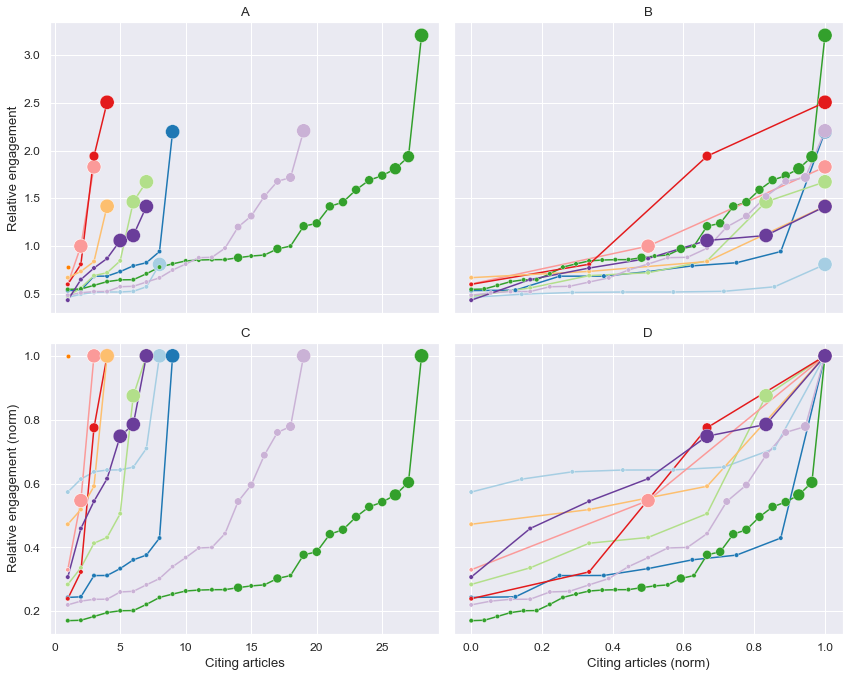

In [250]:
fig, axes = plt.subplots(2, 2, figsize=get_figsize(big, ratio=.8), sharex="col", sharey="row")
with sns.axes_style("darkgrid"):
    ax = axes[0, 0]
    article_profiles(dois, norm_refs=False, ax=ax, palette=palette)
    ax.set_title("A")
    ax.set_xlabel("")
    ax.set_ylabel("Relative engagement")

    ax = axes[0, 1]
    article_profiles(dois, norm_refs=True, ax=ax, palette=palette)
    ax.set_title("B")
    ax.set_xlabel("")
    ax.set_ylabel("")

    ax = axes[1, 0]
    article_profiles(dois, norm_eng=True, ax=ax, palette=palette)
    ax.set_title("C")
    ax.set_xlabel("Citing articles")
    ax.set_ylabel("Relative engagement (norm)")

    ax = axes[1, 1]
    article_profiles(dois, norm_refs=True, norm_eng=True, ax=ax, palette=palette)
    ax.set_title("D")
    ax.set_xlabel("Citing articles (norm)")
    ax.set_ylabel("")

    # fig.suptitle("")
    plt.tight_layout()

### Comparing old and new metrics

In [9]:
article_patterns[article_patterns.refs_agg>1].sort_values("collabs_norm")

,refs_agg,refs_frac_agg,mentions_agg,mentions_mean,mentions_median,mentions_frac_agg,rte_med,rte_avg,collabs,collabs_norm,rte_c,age
10.1007/s12311-016-0794-9,4,0.050675,5,1.250000,1.0,0.052191,0.844818,0.969745,0,0.000000,0.653109,5.0
10.1212/wnl.0000000000004179,6,0.116084,13,2.166667,1.0,0.123466,0.768972,1.470809,0,0.000000,0.285479,4.0
10.3389/fnmol.2017.00258,4,0.108800,4,1.000000,1.0,0.080813,0.753463,0.746491,0,0.000000,0.883602,4.0
10.1038/srep44780,4,0.085334,17,4.250000,3.0,0.176073,2.027869,2.124730,0,0.000000,0.681982,4.0
10.1179/1351000215y.0000000027,19,0.637542,28,1.473684,1.0,0.667027,0.914894,1.041971,0,0.000000,0.468293,5.0
...,...,...,...,...,...,...,...,...,...,...,...,...
10.1631/jzus.b1500247,3,0.088510,3,1.000000,1.0,0.061681,0.738462,0.727635,2,0.666667,0.876410,5.0
10.1021/acs.jmedchem.8b00700,3,0.102961,6,2.000000,1.0,0.095887,0.617021,1.079905,2,0.666667,0.451961,3.0
10.1208/s12248-017-0120-6,4,0.044788,4,1.000000,1.0,0.038737,0.855663,0.863104,3,0.750000,0.913100,4.0
10.1016/j.jalz.2016.11.002,4,0.051046,4,1.000000,1.0,0.042025,0.837880,0.821523,3,0.750000,0.975645,5.0


In [10]:
corr = (
    article_patterns
    .rename(columns=col_names)
    .corr(method="spearman")
    .round(2)
)
corr.to_clipboard()
corr

,Ref count,Frac. ref count,Mention count,mentions_mean,mentions_median,Frac. mention count,RTE-MED,RTE-AVG,collabs,collabs_norm,RTE-C,Publication age
Ref count,1.00,0.89,0.93,0.27,-0.26,0.85,-0.03,0.24,0.71,0.31,-0.71,0.17
Frac. ref count,0.89,1.00,0.83,0.25,-0.21,0.95,0.02,0.21,0.62,0.26,-0.60,0.21
Mention count,0.93,0.83,1.00,0.55,-0.03,0.89,0.14,0.49,0.68,0.30,-0.81,0.14
mentions_mean,0.27,0.25,0.55,1.00,0.58,0.46,0.52,0.89,0.20,0.14,-0.56,-0.03
mentions_median,-0.26,-0.21,-0.03,0.58,1.00,-0.05,0.63,0.51,-0.19,-0.07,0.14,-0.12
Frac. mention count,0.85,0.95,0.89,0.46,-0.05,1.00,0.19,0.44,0.61,0.26,-0.68,0.19
RTE-MED,-0.03,0.02,0.14,0.52,0.63,0.19,1.00,0.69,-0.04,-0.01,0.05,-0.04
RTE-AVG,0.24,0.21,0.49,0.89,0.51,0.44,0.69,1.00,0.17,0.12,-0.53,-0.02
collabs,0.71,0.62,0.68,0.20,-0.19,0.61,-0.04,0.17,1.00,0.81,-0.50,0.13
collabs_norm,0.31,0.26,0.30,0.14,-0.07,0.26,-0.01,0.12,0.81,1.00,-0.17,0.06


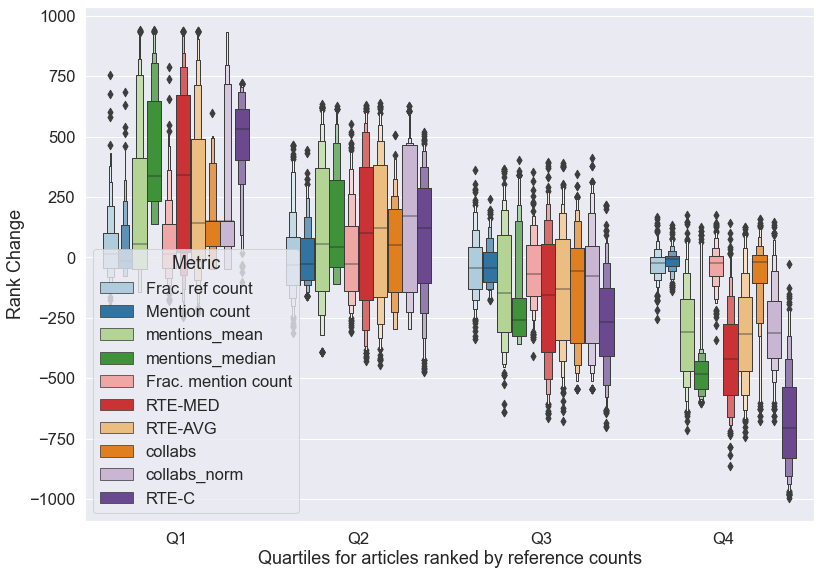

In [11]:
n_quantiles = 5
df = article_patterns.rename(columns=col_names)

base_var = col_names["refs_agg"]

count_methods = df.columns.tolist()
count_methods.remove(base_var)
count_methods.remove(col_names["age"])

df = df.rank()
for cm in count_methods:
    df[cm] = df[cm] - df[base_var]

labels = [f"Q{_}" for _ in range(1, n_quantiles)]

pdf = df.reset_index()
pdf = pdf.join(
    pd.qcut(pdf[base_var], n_quantiles - 1, duplicates="drop", labels=labels).to_frame(
        "qs"
    )
)

pdf = pdf.melt(
    id_vars=["qs", "index"],
    value_vars=count_methods,
    var_name="Metric",
    value_name="Rank Change",
)

sns.boxenplot(data=pdf, hue="Metric", y="Rank Change", x="qs", palette=palette)

plt.xlabel("Quartiles for articles ranked by reference counts")
plt.ylabel("Rank Change")
plt.tight_layout()

In [46]:
(
    article_patterns[article_patterns.refs_agg>=2]
    .rank()
    .sort_values("refs_frac_agg")
    .head(20)
)

,refs_agg,refs_frac_agg,mentions_agg,mentions_frac_agg,rte_med,rte_avg,rte_c,age
10.1242/bio.023432,47.0,1.0,77.0,3.0,811.0,705.0,643.0,407.0
10.1186/s12868-017-0388-6,47.0,2.0,324.0,38.0,877.0,867.0,632.0,407.0
10.1136/bmjopen-2017-019582,47.0,3.0,24.5,2.0,647.0,268.0,861.0,133.0
10.1016/j.nbd.2018.03.014,47.0,4.0,24.5,1.0,21.0,12.0,854.0,133.0
10.1002/ana.24727,47.0,5.0,131.5,26.0,820.0,739.0,839.0,707.5
10.3389/fnins.2018.00585,47.0,6.0,77.0,7.0,691.0,318.0,719.0,133.0
10.3389/fncel.2017.00431,47.0,7.0,24.5,5.0,492.0,187.0,855.0,133.0
10.1016/j.bbagrm.2015.11.006,142.0,8.0,281.5,22.0,108.0,508.0,487.0,707.5
10.2174/1570159x15666170823095628,142.0,9.0,281.5,36.0,842.0,758.0,717.0,133.0
10.5662/wjm.v6.i1.56,142.0,10.0,131.5,23.0,729.0,582.0,644.0,707.5


In [17]:
# Pair plot
# pdf = article_patterns.copy().replace(0, None).dropna()

# log_cols = [
#     "refs_agg",
#     "mentions_agg",
#     "refs_frac_agg",
#     "mentions_frac_agg",
#     "rte_avg",
# ]
# for lc in log_cols:
#     pdf[lc] = np.log10(pdf[lc])
# pdf = pdf[["rte_avg", "rte_c", "refs_frac_agg", "refs_agg"]]
# pdf = pdf.rename(columns=col_names)
# g = sns.pairplot(pdf)
# plt.tight_layout()

### RTE-MED

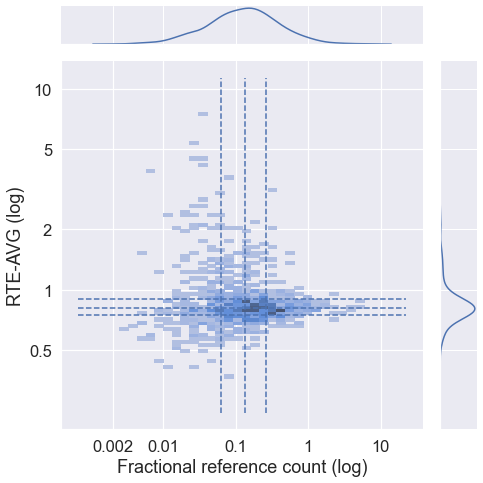

In [14]:
## Citations vs median weighted citation count
x = "refs_frac_agg"
y = "rte_med"

pdf = article_patterns.copy()

pdf[x] = np.log10(pdf[x])
pdf[y] = np.log10(pdf[y])

g = sns.JointGrid(data=pdf, x=x, y=y, height=7, ratio=7)
g.plot_marginals(sns.kdeplot)
g.plot_joint(sns.histplot)

# plt.xscale("log");
# plt.yscale("log");

# Formatting
plt.grid(True, which="minor", ls="--", alpha=0.7)
plt.grid(True, which="major", ls="-", linewidth=1.2)

xticks = [0.002, 0.01, 0.1, 1, 10]
plt.xticks(ticks=np.log10(xticks), labels=xticks)

yticks = [0.5, 1, 2, 5, 10]
plt.yticks(ticks=np.log10(yticks), labels=yticks)

# plot percentiles
x0, x1 = plt.xlim()
y0, y1 = plt.ylim()
plt.hlines(
    np.log10([article_patterns[y].quantile([0.25, 0.5, 0.75])]), x0, x1, linestyles="--"
)
plt.vlines(
    np.log10([article_patterns[x].quantile([0.25, 0.5, 0.75])]), y0, y1, linestyles="--"
)

plt.ylabel("RTE-AVG (log)")
plt.xlabel("Fractional reference count (log)")
plt.tight_layout()

### RTE-AVG

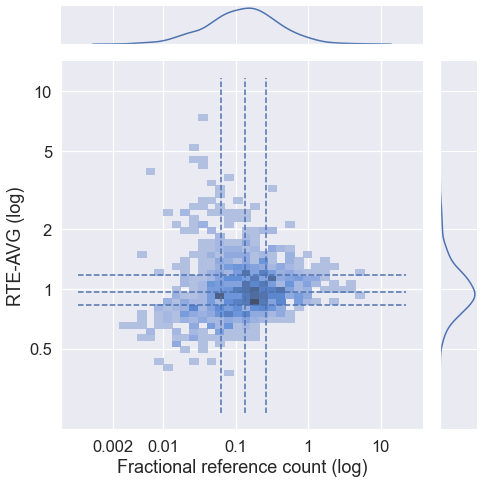

In [53]:
## Citations vs median weighted citation count
x = "refs_frac_agg"
y = "rte_avg"

pdf = article_patterns.copy()

pdf[x] = np.log10(pdf[x])
pdf[y] = np.log10(pdf[y])

g = sns.JointGrid(data=pdf, x=x, y=y, height=7, ratio=7)
g.plot_marginals(sns.kdeplot)
g.plot_joint(sns.histplot)

# plt.xscale("log");
# plt.yscale("log");

# Formatting
plt.grid(True, which="minor", ls="--", alpha=0.7)
plt.grid(True, which="major", ls="-", linewidth=1.2)

xticks = [0.002, 0.01, 0.1, 1, 10]
plt.xticks(ticks=np.log10(xticks), labels=xticks)

yticks = [0.5, 1, 2, 5, 10]
plt.yticks(ticks=np.log10(yticks), labels=yticks)

# plot percentiles
x0, x1 = plt.xlim()
y0, y1 = plt.ylim()
plt.hlines(
    np.log10([article_patterns[y].quantile([0.25, 0.5, 0.75])]), x0, x1, linestyles="--"
)
plt.vlines(
    np.log10([article_patterns[x].quantile([0.25, 0.5, 0.75])]), y0, y1, linestyles="--"
)

plt.ylabel("RTE-AVG (log)")
plt.xlabel("Fractional reference count (log)")
plt.tight_layout()

### RTE-C

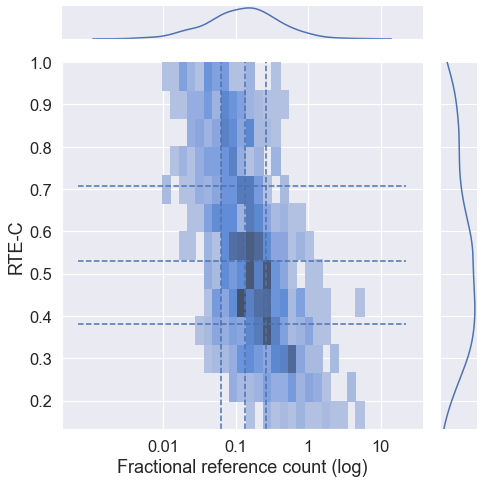

In [54]:
## Citations vs median weighted citation count
x = "refs_frac_agg"
y = "rte_c"

pdf = article_patterns.copy()
pdf[x] = np.log10(pdf[x])

g = sns.JointGrid(data=pdf, x=x, y=y, height=7, ratio=7)
g.plot_marginals(sns.kdeplot)
g.plot_joint(sns.histplot)

# plt.xscale("log");
# plt.yscale("log");

# Formatting
plt.grid(True, which="minor", ls="--", alpha=0.7)
plt.grid(True, which="major", ls="-", linewidth=1.2)

xticks = [0.01, 0.1, 1, 10]
plt.xticks(ticks=np.log10(xticks), labels=xticks)

# yticks = [0.5, 1, 2, 5, 10]
# plt.yticks(ticks=np.log10(yticks), labels=yticks)
plt.ylim(pdf[y].min(), 1)

# plot percentiles
x0, x1 = plt.xlim()
y0, y1 = plt.ylim()

plt.hlines([article_patterns[y].quantile([0.25, 0.5, 0.75])], x0, x1, linestyles="--")
plt.vlines(
    np.log10([article_patterns[x].quantile([0.25, 0.5, 0.75])]), y0, y1, linestyles="--"
)


plt.ylabel("RTE-C")
plt.xlabel("Fractional reference count (log)")
plt.tight_layout()

### Combined

In [119]:
min_cites = 5

pdf = article_patterns.copy()
pdf = pdf[pdf["refs_agg"] >= min_cites]

# Add selection of high-performing articles
pdf = pdf[
#     (pdf["refs_frac_agg"] >= pdf["refs_frac_agg"].quantile(0.25)) & 
    (pdf["rte_med"] >= pdf["rte_med"].quantile(0.9))
    & (pdf["rte_c"] >= pdf["rte_c"].quantile(0.5))
]

high_dois = pdf.index
len(high_dois)

43

  0%|          | 0/43 [00:00<?, ?it/s]

<AxesSubplot:xlabel='x_perc', ylabel='mentions_norm_mean'>

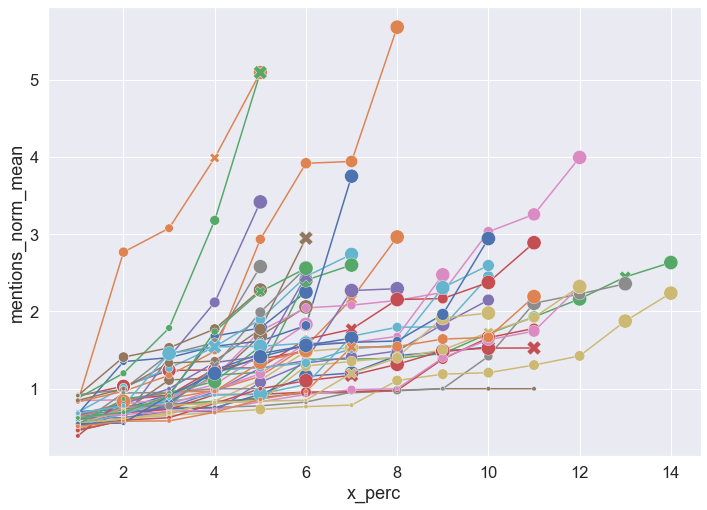

In [142]:
article_profiles(high_dois, common_authors=True)

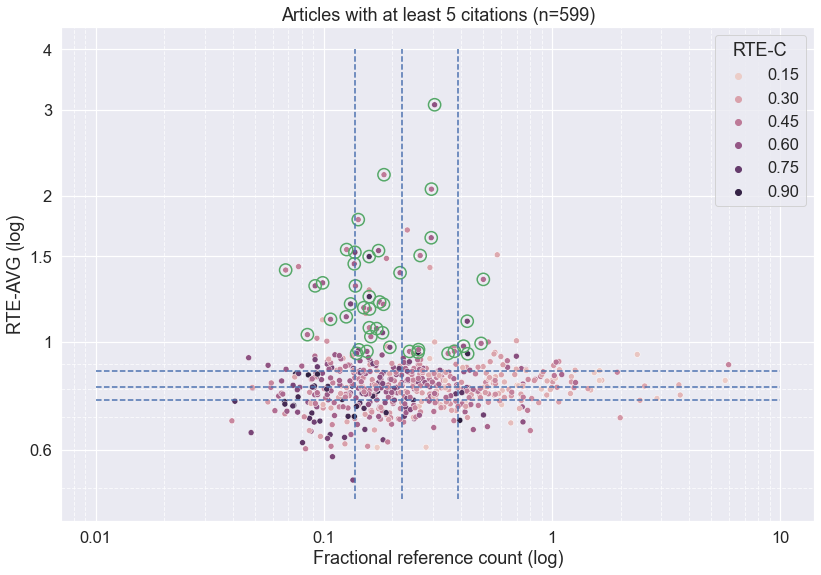

In [121]:
## Citations vs median weighted citation count
y = "rte_med"
x = "refs_frac_agg"
hue = "rte_c"

pdf = article_patterns[article_patterns.refs_agg >= min_cites].copy()

sns.scatterplot(
    data=pdf.rename(columns=col_names),
    y=col_names[y],
    x=col_names[x],
    hue=col_names[hue],
    sizes=(30, 400),
)

plt.grid(True, which="minor", ls="--", alpha=0.7)
plt.grid(True, which="major", ls="-", linewidth=1.2)

plt.loglog()

xticks = [.01, 0.1, 1, 10]
plt.xticks(ticks=xticks, labels=xticks);

yticks = [.6, 1, 1.5, 2, 3, 4]
plt.yticks(ticks=yticks, labels=yticks)

x0, x1 = plt.xlim()
y0, y1 = plt.ylim()

plt.hlines([pdf[y].quantile([0.25, 0.5, 0.75])], x0, x1, linestyles="--")
plt.vlines([pdf[x].quantile([0.25, 0.5, 0.75])], y0, y1, linestyles="--")

# Add highlights for high performing articles
xs = pdf.loc[high_dois][x]
ys = pdf.loc[high_dois][y]

plt.scatter(xs, ys, marker="o", s=150, linewidth=1.5, edgecolors="g", facecolors="none")

plt.title(f"Articles with at least {min_cites} citations (n={len(pdf)})")
plt.ylabel("RTE-AVG (log)")
plt.xlabel("Fractional reference count (log)")
plt.tight_layout()

  0%|          | 0/599 [00:00<?, ?it/s]

  0%|          | 0/43 [00:00<?, ?it/s]

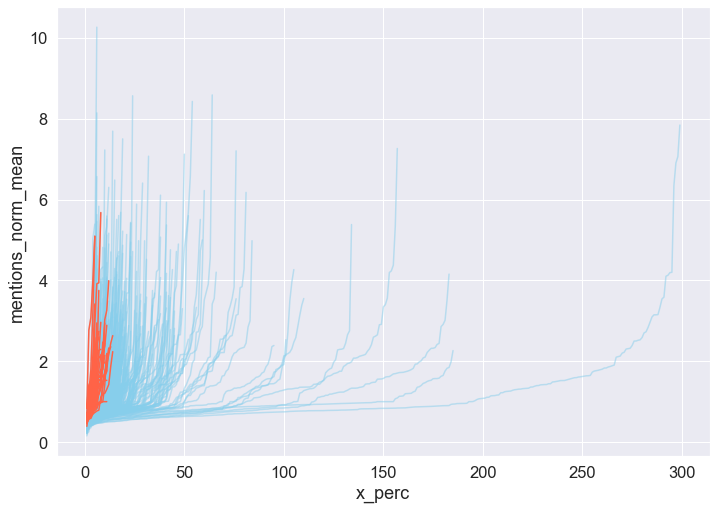

In [122]:
pdf = article_patterns[article_patterns.refs_agg >= min_cites]

ax = article_profiles(pdf.index, color="skyblue", scatter=False, alpha=0.5)
article_profiles(high_dois, color="tomato", ax=ax, scatter=False);

  0%|          | 0/883 [00:00<?, ?it/s]

  0%|          | 0/30 [00:00<?, ?it/s]

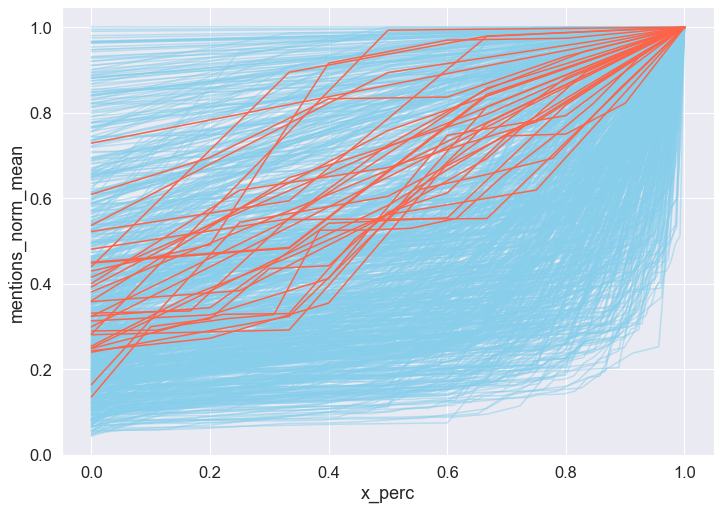

In [106]:
pdf = article_patterns[article_patterns.refs_agg >= min_cites]

ax = article_profiles(pdf.index, color="skyblue", norm_eng=True, norm_refs=True, scatter=False, alpha=0.5)
article_profiles(high_dois, color="tomato", norm_eng=True, norm_refs=True, ax=ax, scatter=False);